# Importy

In [1]:
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import pandas as pd
from scipy.interpolate import CubicSpline
from statsmodels.graphics.mosaicplot import mosaic
import plot_likert
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import binomtest
from statsmodels.stats.proportion import proportions_ztest

import os
os.environ["R_HOME"] = r"C:\\Program Files\\R\\R-4.2.3" 
os.environ["PATH"] = r"C:\\Program Files\\R\\R-4.2.3\\bin\\x64" + ";" + os.environ["R_HOME"]
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
pandas2ri.activate()
stats_r = importr('stats')
graphics = importr('graphics')

sns.set()

plt.rc('figure', figsize=(10, 6))
plt.rc('font', size=12)

%load_ext rpy2.ipython

c:\Users\jakub\AppData\Local\Programs\Python\Python311\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


# Raport 2

**Nazwa kursu:** Analiza danych ankietowych

**Prowadzący:** dr Rafał Połoczański

**Autorzy:** Antczak Jakub (268745), Curkowicz Kinga (268774)

**Rok akademicki:** 2023/2024

## Spis treści

1. [Część I](#Część-I)
    - [Zadanie 1](#Zadanie-1)
    - [Zadanie 2](#Zadanie-2)
    - [Zadanie 3](#Zadanie-3)
    - [Zadanie 4](#Zadanie-4)
    - [Zadanie 5](#Zadanie-5)
    - [Zadanie 6](#Zadanie-6)
    - [Zadanie 7](#Zadanie-7)
    - [Zadanie 8](#Zadanie-8)
2. [Część II](#Część-II)
    - [Zadanie 4](#Zadanie-4)
    - [Zadanie 5](#Zadanie-5)
    - [Zadanie 6](#Zadanie-6)
3. [Część III](#Część-III)
    - [Zadanie 7](#Zadanie-7)
    - [Zadanie 8](#Zadanie-8)
    - [Zadanie 9](#Zadanie-9)
    - [Zadanie 10](#Zadanie-10)
4. [Część IV](#Część-IV-V)
    - [Zadanie 11](#Zadanie-11)
    - [Zadanie 12](#Zadanie-12)
    - [Zadanie 13](#Zadanie-13)
    - [Zadanie 14](#Zadanie-14)
5. [Zadania dodatkowe](#Zadania-dodatkowe)

# Część 1

## Zadanie 1

W tym zadaniu mieliśmy wyznaczyć przedział ufności dla wektora prawdopodobieństw opisującego stopień zadowolenia z podejścia firmy. Przyjęliśmy poziom ufności $0.95$.

Skorzystaliśmy z funkcji wbudowanej $\texttt{proportion\_confint}$, w której użyliśmy $\texttt{method='normal'}$ (przybliżenie rozkładem normalnym). Górna granica przedziału ufności to 

$$upper\_bound=p+z\sqrt{\frac{p(1-p)}{n}}$$
a dolna granica to 
$$lower\_bound=p-z\sqrt{\frac{p(1-p)}{n}}$$

gdzie $p$ to obserwowana proporcja, $n$ to liczność próby, a $z$ to wartość krytyczna rozkładu normalnego (np. dla $0.95$ wynosi $1.96$).

In [2]:
df = pd.read_csv('ankieta.csv', sep=';', encoding='unicode_escape')
df.rename(columns={'DZIA£': 'DZIAŁ', 'STA¯': 'STAŻ', 'P£EÆ': 'PŁEĆ'}, inplace=True)
df.head()

,DZIAŁ,STAŻ,CZY_KIER,PYT_1,PYT_2,PYT_3,PŁEĆ,WIEK
0,IT,2,Nie,1,-2,1,M,64
1,IT,2,Nie,0,-2,-2,M,67
2,IT,2,Nie,1,2,2,M,65
3,IT,2,Nie,-1,-2,-2,K,68
4,IT,3,Tak,1,2,-1,K,65


In [3]:
data=[[-2,14/200],[-1,17/200],[0,40/200],[1,100/200],[2,29/200]]
n=200
df_new=pd.DataFrame(data,columns=['Odpowiedź','Prawdopodobieństwo'])
df_new

,Odpowiedź,Prawdopodobieństwo
0,-2,0.070
1,-1,0.085
2,0,0.200
3,1,0.500
4,2,0.145


In [4]:
alpha=0.05
ci=proportion_confint(df_new['Prawdopodobieństwo']*n,n,alpha=alpha,method='normal')

df_new['Dolna granica']=ci[0]
df_new['Górna granica']=ci[1]
df_new

,Odpowiedź,Prawdopodobieństwo,Dolna granica,Górna granica
0,-2,0.070,0.034639,0.105361
1,-1,0.085,0.046350,0.123650
2,0,0.200,0.144564,0.255436
3,1,0.500,0.430705,0.569295
4,2,0.145,0.096202,0.193798


Widzimy, że wszystkie wartości prawdopodbieństw leżą w odpowiednich przedziałach ufności.

## Zadanie 2

W zadaniu 2 stworzyliśmy funkcję, która wyznacza poziom wartości krytycznej w testach chi-kwadrat Pearsona oraz chi-kwadrat największej wiarygodności. Oba testy służą do weryfikacji hipotezy
$H_0: p=p_0$ przeciwko $H_1: p\neq p_0$. na podstawie obserwacji $x$ wektora losowego $X$ z rozkładu wielomianowego z parametrami $n$ i $p$.

Wzór na statystykę testu chi-kwadrat Pearsona to:
$\chi^2 = \sum \frac{(O_i - E_i)^2}{E_i}$

P-wartość dla testu chi-kwadrat Pearsona to:
$p\text{-value} = 1 - F_{\chi^2}( \chi^2, \text{df})$

Wzór na statystykę testu chi-kwadrat największej wiarygodności to:
$G^2 = 2 \sum O_i \ln\left(\frac{O_i}{E_i}\right)$

P-wartość dla testu chi-kwadrat największej wiarygodności to:
$p\text{-value} = 1 - F_{\chi^2}( G^2, \text{df})$

In [5]:
def pearson_chi2_pvalue(observed,p0):
    """
    Calculate the p-value for Pearson's chi-square test.

    This function computes the p-value for Pearson's chi-square test
    based on observed frequencies and expected probabilities under the
    null hypothesis.

    Parameters:
    observed (list or numpy array): Observed frequencies in each category.
    p0 (list or numpy array): Expected probabilities under the null hypothesis.

    Returns:
    float: The p-value for Pearson's chi-square test.
    """
    n = np.sum(observed)
    expected = n * np.array(p0)
    chi2_stat, p_value = scipy.stats.chisquare(observed, expected)
    return p_value

In [6]:
def pearson_chi2_likelihood_pvalue(observed,p0):
    """
    Calculate the p-value for the likelihood ratio chi-square test.

    This function computes the p-value for the likelihood ratio chi-square test
    based on observed frequencies and expected probabilities under the null hypothesis.

    Parameters:
    observed (list or numpy array): Observed frequencies in each category.
    p0 (list or numpy array): Expected probabilities under the null hypothesis.

    Returns:
    float: The p-value for the likelihood ratio chi-square test.
    """
    observed = np.array(observed)
    n = np.sum(observed)
    expected = n * np.array(p0)
    
    observed_nonzero = observed[expected > 0]
    expected_nonzero = expected[expected > 0]
    
    log_likelihood_ratio = 2 * np.sum(observed_nonzero * np.log(observed_nonzero / expected_nonzero))
    degrees_of_freedom = len(observed) - 1
    p_value = 1 - scipy.stats.chi2.cdf(log_likelihood_ratio, degrees_of_freedom)
    return p_value

Wygenerowanie próbki z rozkladu wielomianowego z przyjętymi parametrami $n$ i $p$.

In [7]:
n = 100 
p0 = [0.3, 0.5, 0.2] 
observed_values = np.random.multinomial(n, p0)

Poziom wartości krytycznej (p-value) dla testu Chi-Squared-Pearsona dla $\alpha = 0.05$

In [8]:
alpha=0.05
pearson_chi2_pvalue(observed_values,p0)

0.7710515858035664

Wartość krytyczna dla testu Chi-Squared-Likelihood dla $\alpha = 0.05$

In [9]:
pearson_chi2_likelihood_pvalue(observed_values,p0)

0.7719666007708815

## Zadanie 3

W zadaniu drugim chcemy zweryfikować hipotezę, że rozkład prawdopodobieństwa odpowiedzi na $\texttt{PYT\_2}$ jest jednakowy dla Działu Kreatywnego.

Aby to zrobić skorzystamy z funkcji napisanej w zadaniu 2, natomiast potrzebujemy również wartości statystyk dla poszczególnych testów, a nie tylko wartości krytycznych. W tym celu napisaliśmy funkcję do obliczania wartości statystyk.

Statystyka dla testu Chi-Squared-Pearsona:

$\chi^2_{Pearson}=\sum_{i=1}^k\frac{x_i-n\cdot p_i}{n\cdot p_i}$

Statystyka dla testu Chi-Squared-Likelihood:

$\chi^2_{Likelihood}=2\sum_{i=1}^k x_i\log\left(\frac{x_i}{n\cdot p_i}\right)$

In [10]:
def statistic_chi2_pearson(n,x,p):
    """
    Calculate the Pearson's chi-squared statistic for testing goodness of fit.

    Parameters:
    - n (int or array-like): Sample size or array-like object containing observed frequencies for each category.
    - x (int or array-like): Number of successes or array-like object containing observed frequencies for each category.
    - p (float or array-like): Expected probability of success for each category or array-like object containing
                               expected probabilities for each category.

    Returns:
    - float: Pearson's chi-squared statistic.

    The function calculates the Pearson's chi-squared statistic for testing goodness of fit of observed frequencies
    to expected frequencies under the null hypothesis of independence. It compares observed frequencies (x) with
    expected frequencies (n*p) and computes the squared differences, divided by the expected frequencies, and summed
    over all categories. This statistic is commonly used in chi-squared tests for categorical data analysis.
    """
    stat=np.sum((x-n*p)**2/(n*p))
    return stat

In [11]:
def stat_chi2_likelihood(n,x,p):
    """
    Calculate the likelihood ratio chi-squared statistic for testing goodness of fit.

    Parameters:
    - n (int or array-like): Sample size or array-like object containing observed frequencies for each category.
    - x (int or array-like): Number of successes or array-like object containing observed frequencies for each category.
    - p (float or array-like): Expected probability of success for each category or array-like object containing
                               expected probabilities for each category.

    Returns:
    - float: Likelihood ratio chi-squared statistic.

    The function calculates the likelihood ratio chi-squared statistic for testing goodness of fit of observed
    frequencies to expected frequencies under the null hypothesis of independence. It compares observed frequencies
    (x) with expected frequencies (n*p) and computes the log likelihood ratio for each category, multiplied by the
    observed frequency, summed over all categories, and multiplied by 2. This statistic is commonly used in
    likelihood ratio tests for categorical data analysis.
    """
    stat=2*np.sum(x*np.log(x/(n*p)))
    return stat

In [12]:
dzial_kreatywny=df[df['DZIAŁ']=='DK']
dzial_kreatywny.reset_index(drop=True,inplace=True)
alpha=0.05
prob=0.2
dzial_kreatywny

,DZIAŁ,STAŻ,CZY_KIER,PYT_1,PYT_2,PYT_3,PŁEĆ,WIEK
0,DK,2,Tak,1,2,2,M,28
1,DK,1,Nie,1,2,2,M,26
2,DK,1,Nie,-1,-2,-2,M,25
3,DK,1,Nie,0,-2,1,M,27
4,DK,1,Nie,1,2,2,M,32
...,...,...,...,...,...,...,...,...
93,DK,2,Nie,1,2,2,M,38
94,DK,2,Tak,1,-1,1,M,41
95,DK,2,Tak,0,-2,2,M,44
96,DK,2,Nie,2,-2,-2,M,42


In [13]:
n=len(dzial_kreatywny)

a=sum(dzial_kreatywny['PYT_1'] == -2)
b=sum(dzial_kreatywny['PYT_1'] == -1)
c=sum(dzial_kreatywny['PYT_1'] == 0)
d=sum(dzial_kreatywny['PYT_1'] == 1)
e=sum(dzial_kreatywny['PYT_1'] == 2)

x=np.array([a,b,c,d,e])
x

array([ 9, 10, 17, 51, 11])

Wartość krytyczna dla testu chi2-Pearsona:

In [14]:
criticalzad2=pearson_chi2_pvalue(x,prob)
criticalzad2

2.7578344347347053e-13

Wartość krytyczna dla testu chi2-Likelihood:

In [15]:
likelihoodzad2=pearson_chi2_likelihood_pvalue(x,prob)
likelihoodzad2

1.0701994845874196e-10

Wartość statystyki dla testu chi2-Pearsona:

In [16]:
statzad2_chi2_pearson=statistic_chi2_pearson(n,x,prob)
statzad2_chi2_pearson

64.85714285714285

Odrzucamy hipotezę zerową, ponieważ wartość statystyki jest większa od wartości krytycznej.

Wartość statystyki dla testu chi2-Likelihood:

In [17]:
statzad2_chi2_likelihood=stat_chi2_likelihood(n,x,prob)
statzad2_chi2_likelihood

52.52711350694117

Odrzucamy hipotezę zerową, ponieważ wartość statystyki jest większa od wartości krytycznej.

Wszystkie hipotezy zostały odrzucone, a zatem rozkład prawdopodobieństw nie jest jednakowy.

# Część II

## Zadanie 4 

Zapoznaliśmy się

## Zadanie 5

Dokładny test Fishera jest używany do oceny niezależności dwóch zmiennych kategorycznych. W tym zadaniu korzystając z funkcji wbudowanej $\texttt{fisher\_exact}$ zweryfikujemy hipotezę, że zmienna $\texttt{PŁEĆ}$ jest niezależna od zmiennej $\texttt{CZY\_KIER}$. Użyjemy domyślnego parametru $\texttt{alternative='two-sided'}$, ta alternatywa sugeruje nam, że istnieje jakiś rodzaj związku między danymi, ale nie określa kierunku tego związku.

Przyjęliśmy poziom istotności $\alpha=0.05$.

In [18]:
alpha=0.05
new_df=pd.crosstab(df['PŁEĆ'],df['CZY_KIER'])

In [19]:
odds_ratio, p_value = scipy.stats.fisher_exact(new_df)
odds_ratio, p_value

(1.3602272727272726, 0.6659028889666552)

Nie ma podstaw do odrzucenia hipotezy zerowej, ponieważ wartość p-value jest większa od poziomu istotności.

Czy jesteśmy w stanie stwierdzić, że na stanowisku kierowniczym pracuje tyle samo kobiet co mężczyzn? Nie, brak odrzucenia hipotezy zerowej nie oznacza, że oba prawdopodieństwa są równe. Oznacza to jedynie, że nie ma statystycznie istotnej różnicy między płcią a byciem kierownikiem na podstawie przeprowadzonego testu.

W tym zadaniu dodatkowo sprawdziliśmy jak wyglądałby wynik testu, gdybyśmy użyli funkcji $\texttt{chi2\_contingency}$, która działa dla większych tablic nie o wymiarze 2x2.

In [20]:
chi2, p_value, dof, expected=scipy.stats.chi2_contingency(new_df)
p_value

0.6389361327391145

Znów nie mamy podstaw do odrzucenia hipotezy zerowej, ponieważ wartość p-value jest większa od poziomu istotności, co jest zgodne z wynikiem uzyskanym wcześniej.

## Zadanie 6

Wiemy, że test Fishera jest uogólnieniem testu Freemana-Haltona dla tablic o rozmiarze 2x2. W tym zadaniu chcemy zweryfikować hipotezy niezalezności dla tablic nie o wymierze 2x2, w tym celu musimy skorzystać z funkcji $\texttt{chi2\_contingency}$, która zwraca wartość statystyki testowej oraz wartość p-value.

In [21]:
df['WIEK_KAT'] = pd.cut(df['WIEK'], bins=[0, 35, 45, 55, 100], labels=['do 35 lat', '36-45', '46-55', 'powyzej 55'])
df

,DZIAŁ,STAŻ,CZY_KIER,PYT_1,PYT_2,PYT_3,PŁEĆ,WIEK,WIEK_KAT
0,IT,2,Nie,1,-2,1,M,64,powyzej 55
1,IT,2,Nie,0,-2,-2,M,67,powyzej 55
2,IT,2,Nie,1,2,2,M,65,powyzej 55
3,IT,2,Nie,-1,-2,-2,K,68,powyzej 55
4,IT,3,Tak,1,2,-1,K,65,powyzej 55
...,...,...,...,...,...,...,...,...,...
195,HR,2,Nie,1,2,2,M,42,36-45
196,HR,2,Nie,1,-1,-1,K,35,do 35 lat
197,HR,2,Nie,-1,-2,-2,K,39,36-45
198,HR,2,Nie,1,2,1,K,48,46-55


Zajmowanie stanowiska kierowniczego nie zależy od wieku:

In [22]:
new_df1=pd.crosstab(df['WIEK_KAT'],df['CZY_KIER'])

chi2, p_value, dof, expected=scipy.stats.chi2_contingency(new_df1)
p_value

0.7818279913988688

Nie ma podstaw do odrzucenia hipotezy zerowej, ponieważ wartość p-value jest większa od poziomu istotności.

Zajmowanie stanowiska kierowniczego nie zalezy od stażu pracy:

In [23]:
new_df2=pd.crosstab(df['STAŻ'], df['CZY_KIER'])

chi2, p_value, dof, expected=scipy.stats.chi2_contingency(new_df2)
p_value


9.258630522237527e-06

Odrzucamy hipotezę zerową, ponieważ p-wartość jest mniejsza od poziomu istotności.

Zadowolenie z wynagrodzenia w pierwszym badanym okresie nie zależy od zajmowanego stanowiska:

In [24]:
new_df3=pd.crosstab(df['PYT_2'], df['CZY_KIER'])

chi2, p_value, dof, expected=scipy.stats.chi2_contingency(new_df3)
p_value


0.0043970813557677796

Odrzucamy hipotezę zerową, ponieważ p-wartość jest mniejsza od poziomu istotności.

Zadowolenie z wynagrodzenia w pierwszym badanym okresie nie zależy od stażu:

In [25]:
new_df4=pd.crosstab(df['PYT_2'], df['STAŻ'])

chi2, p_value, dof, expected=scipy.stats.chi2_contingency(new_df4)
p_value

0.00021153098719568693

Odrzucamy hipotezę zerową, ponieważ p-wartość jest mniejsza od poziomu istotności.

Zadowolenie z wynagrodzenia w pierwszym badanym okresie nie zależy od płci:

In [26]:
new_df5=pd.crosstab(df['PYT_2'], df['PŁEĆ'])

chi2, p_value, dof, expected=scipy.stats.chi2_contingency(new_df5)
p_value

0.5182765559878681

Nie ma podstaw do odrzucenia hipotezy zerowej, ponieważ wartość p-value jest większa od poziomu istotności.

Zadowolenie z wynagrodzenia w pierwszym badanym okresie nie zależy od wieku:

In [27]:
new_df6=pd.crosstab(df['WIEK_KAT'], df['PYT_2'])

chi2, p_value, dof, expected=scipy.stats.chi2_contingency(new_df6)
p_value

0.36311016909097266

Nie ma podstaw do odrzucenia hipotezy zerowej, ponieważ wartość p-value jest większa od poziomu istotności.

# Część III

## Zadanie 7

Zapoznaliśmy się.

## Zadanie 8

W tym zadaniu chcemy zweryfikować hipotezę, że zmienna $\texttt{CZY\_KIER}$ jest niezależna od zmiennej $\texttt{PYT\_2}$. W tym celu skorzystamy z funkcji $\texttt{chi2\_contingency}$, która zwraca wartość statystyki testowej oraz wartość p-value. Przyjmijmy poziom istotności $\alpha=0.01$.

Wersja python:

In [28]:
new_df7 = pd.crosstab(df['PYT_2'], df['CZY_KIER'])

chi2, p_value, dof, expected = scipy.stats.chi2_contingency(new_df7)
p_value

0.0043970813557677796

Odrzucamy hipotezę zerową, ponieważ p-wartość jest mniejsza od poziomu istotności.

Wersja R:

In [29]:
data_r_matrix = ro.r.matrix(new_df7.to_numpy(), nrow=new_df7.shape[0], ncol=new_df7.shape[1])
data_r_matrix.colnames = ro.StrVector(new_df7.columns)
data_r_matrix.rownames = ro.StrVector(new_df7.index.astype(str))

test_result = stats_r.chisq_test(data_r_matrix)
print(test_result)


	Pearson's Chi-squared test

data:  structure(c(64L, 18L, 0L, 91L, 10L, 2L, 2L, 13L), dim = c(4L, 2L), dimnames = list(c("-2", "-1", "1", "2"), c("Nie", "Tak")))
X-squared = 13.114, df = 3, p-value = 0.004397




Odrzucamy hipotezę zerową, ponieważ p-wartość jest mniejsza od poziomu istotności. Widzimy, że wyniki są te same (również w zadaniu 6).

Exception ignored from cffi callback <function _consolewrite_ex at 0x0000020F19A0FC40>:
Traceback (most recent call last):
  File "c:\Users\jakub\AppData\Local\Programs\Python\Python311\Lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jakub\AppData\Local\Programs\Python\Python311\Lib\site-packages\rpy2\rinterface_lib\conversion.py", line 138, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf3 in position 79: invalid continuation byte
Exception ignored from cffi callback <function _consolewrite_ex at 0x0000020F19A0FC40>:
Traceback (most recent call last):
  File "c:\Users\jakub\AppData\Local\Programs\Python\Python311\Lib\site-packages\rpy2\rinterface_lib\callbacks.py", lin

Exception ignored from cffi callback <function _consolewrite_ex at 0x0000020F19A0FC40>:
Traceback (most recent call last):
  File "c:\Users\jakub\AppData\Local\Programs\Python\Python311\Lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jakub\AppData\Local\Programs\Python\Python311\Lib\site-packages\rpy2\rinterface_lib\conversion.py", line 138, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf3 in position 79: invalid continuation byte
Exception ignored from cffi callback <function _consolewrite_ex at 0x0000020F19A0FC40>:
Traceback (most recent call last):
  File "c:\Users\jakub\AppData\Local\Programs\Python\Python311\Lib\site-packages\rpy2\rinterface_lib\callbacks.py", lin

In addition: Warning messages:
1: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
 2: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
 3: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
 4: In (function (x, y = NULL, correct = TRUE, p = rep(1/length(x),  :
 

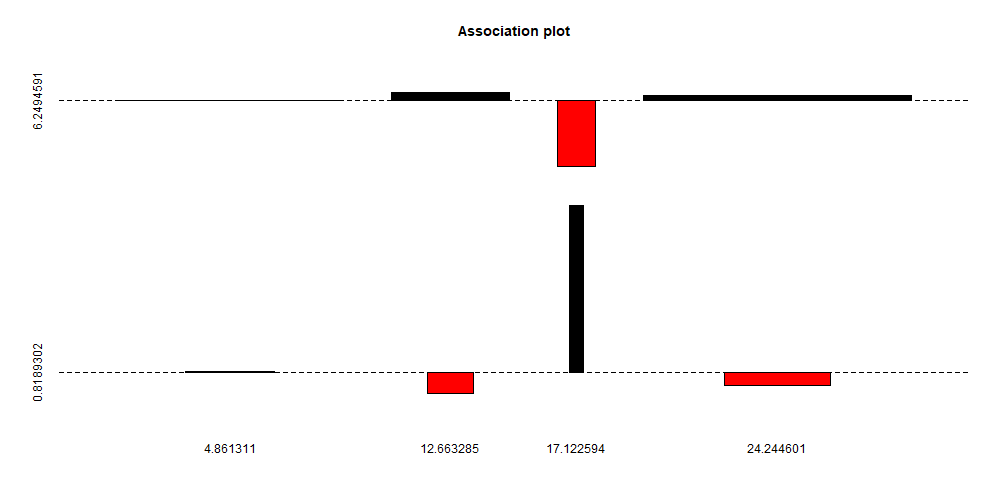

In [30]:
data_r_matrix = ro.r.matrix(new_df7.to_numpy(), nrow=new_df7.shape[0], ncol=new_df7.shape[1])
%R -i data_r_matrix
%R -w 1000 -h 500 -u px graphics::assocplot(data_r_matrix); title('Association plot')

## Zadanie 9

W tym zadaniu chcemy obliczyć moce testu dla testu Fishera oraz mocy testu chi-kwadrat Pearsona, generując dane z tabeli 2x2. Symulacje wykonamy dla $n=50,100,1000$. Wartość $\texttt{power}$ obliczymy jako iloraz całkowitej liczby odrzuceń hipotezy zerowej do liczby wszystkich symulacji.

In [31]:
def power(sample_size, probabilities, num_simulations=10000, significance_level=0.05):
    """
    Computes the power of Chi-squared and Fisher's exact tests for different sample sizes.

    Parameters:
    sample_size (int): The size of the sample.
    probabilities (list): A list of probabilities for each category.
    num_simulations (int): The number of simulations to perform (default is 10000).
    significance_level (float): The significance level for the tests (default is 0.05).

    Returns:
    tuple: The power of the Chi-squared and Fisher's exact tests as values between 0 and 1.
    """
    power_chi2 = 0
    power_fisher = 0
    
    for _ in range(num_simulations):
        sample = np.random.multinomial(sample_size, probabilities).reshape(2, 2)
        
        _, p_value_chi2, _, _ = scipy.stats.chi2_contingency(sample + 0.00001) # to avoid division by zero
        if p_value_chi2 < significance_level:
            power_chi2 += 1
        
        _, p_value_fisher = scipy.stats.fisher_exact(sample)
        if p_value_fisher < significance_level:
            power_fisher += 1
            
    return power_chi2 / num_simulations, power_fisher / num_simulations


In [32]:
sample_sizes = [50, 100, 1000]
probabilities = [1/40, 3/40, 19/40, 17/40]
significance_level = 0.05
num_simulations = 1000

results = []

for size in sample_sizes:
    chi2_power, fisher_power = power(size, probabilities, num_simulations=num_simulations, significance_level=significance_level)
    results.append({'n': size, 'chi2': chi2_power, 'fisher': fisher_power})

results_df = pd.DataFrame(results)

In [33]:
results_df

,n,chi2,fisher
0,50,0.076,0.113
1,100,0.260,0.329
2,1000,0.999,0.999


Widzimy, że moc testu Fishera jest większa niż moc testu chi-kwadrat Pearsona dla wszystkich wartości $n$, natomiast wraz ze wzrostem n obie moce testów zaczynają się zbiegać.

## Zadanie 10

W tym zadaniu napiszemy funkcję, która dla danych z taliby dwudzielczej oblicza wartość poziomu krytycznego w teście chi-kwadrat Pearsona. 

Stopnie swobody dla testu chi-kwadrat są obliczane na podstawie wymiarów tabeli kontyngencji.

Wartość krytyczna jest obliczana za pomocą funkcji $\texttt{chi2.ppf}$, która zwraca kwantyl odwrotny funkcji dystrybuanty chi-kwadrat. Wartość ta jest obliczana dla $1-\alpha$ oraz liczby stopni swobody.

Zbadamy równiez hipotezę zerową: Czy zadowolenie z wynagrodzenia w pierwszym badanym okresie nie zależy od zajmowanego stanowiska?

In [34]:
def critical_table_value(contingency_table, significance_level):
    """
    Computes the critical table value for the chi-squared test.

    Parameters:
    contingency_table (array-like): The contingency table.
    significance_level (float): The significance level for the test.

    Returns:
    float: The critical table value for the chi-squared test.
    """
    dof = (contingency_table.shape[0] - 1) * (contingency_table.shape[1] - 1)
    critical_value = scipy.stats.chi2.ppf(1 - significance_level, dof)
    return critical_value

Krytyczna wartość statystyki testu chi-kwadrat:

In [35]:
alpha = 0.05
df10 = pd.crosstab(df['PYT_2'], df['CZY_KIER'])

critical_value = critical_table_value(df10, alpha)
critical_value

7.814727903251179

Wartość statystyki testu chi-kwadrat:

In [37]:
chi2, p_value, dof, expected = scipy.stats.chi2_contingency(df10)
p_value

0.0043970813557677796

Nie ma podstaw do odrzucenia hipotezy zerowej, gdyż wartość statystyki testu jest mniejsza od wartości krytycznej.

# Część IV

## Zadanie 11

Celem zadania jest zbadanie związku między paleniem papierosów, a śmiercią z powodu raka płuc oraz związku między paleniem papierosów, a śmiercią z powodu choroby niedokrwiennej serca na podstawie danych z 20-letniego badania przeprowadzonego wśród brytyjskich mężczyzn. Obliczymy różnice proporcji, ryzyko względne oraz iloraz szans na podstawie wzorów z wykładu.

In [43]:
cancer_lungs_smoked=0.0014
cancer_lungs_non_smoked=0.0001

cancer_heart_smoked=0.00669
cancer_heart_non_smoked=0.00413

Różnica proporcji dla śmierci z powodu raka płuc:

In [44]:
cancer_lungs_smoked-cancer_lungs_non_smoked

0.0013

Różnica proporcji dla śmierci z powodu choroby serca:

In [45]:
cancer_heart_smoked-cancer_heart_non_smoked

0.0025599999999999998

Ryzyko względne dla śmierci z powodu raka płuc:

In [46]:
cancer_lungs_smoked/cancer_lungs_non_smoked

14.0

Ryzyko względne dla śmierci z powodu choroby serca:

In [47]:
cancer_heart_smoked/cancer_heart_non_smoked

1.6198547215496368

Iloraz szans dla śmierci z powodu raka płuc:

In [48]:
omega_1=cancer_lungs_smoked/(1-cancer_lungs_smoked)
omega_2=cancer_lungs_non_smoked/(1-cancer_lungs_non_smoked)

omega_1/omega_2

14.01822551572201

Iloraz szans dla śmierci z powodu choroby serca:

In [49]:
omega_3=cancer_heart_smoked/(1-cancer_heart_smoked)
omega_4=cancer_heart_non_smoked/(1-cancer_heart_non_smoked)

omega_3/omega_4

1.6240294787625582

Możemy zauważyć, że palenie:

- zwiększa roczny odsetek zgonów z powodu raka płuc o 0.13%,
- zwiększa roczny odsetek zgonów z powodu choroby niedokrwiennej serca o 0.26%,
- prowadzi do 14 razy większego ryzyka śmierci z powodu raka płuc,
- ma około 1.62 razy większe ryzyko śmierci z powodu choroby niedokrwiennej serca niż niepalenie,
- zwiększa około 14 razy szanse na zgon z powodu raka płuc,
- zwiększa około 1.62 razy szanse na zgon z powodu choroby niedokrwiennej serca.

**Wnioski:**

Związek między paleniem papierosów a śmiercią z powodu raka płuc jest znacznie silniejszy niż związek między paleniem papierosów a śmiercią z powodu choroby niedokrwiennej serca. Wskaźniki ryzyka względnego i ilorazu szans dla raka płuc są znacznie wyższe niż dla choroby niedokrwiennej serca, co sugeruje, że palenie ma silniejszy wpływ na ryzyko zachorowania na raka płuc.

## Zadanie 12

W tym zadaniu obliczymy zadane prawdopodobieństwa na podstawie danych dotyczących śmiertelności w wypadkach samochodowych na Florydzie w 2008 roku. Następnie wyznaczymy różnicę proporcji, ryzyko względne, iloraz szans oraz zinterpretujemy otrzymane wyniki.

In [50]:
dead_without_belt=1085
dead_with_belt=703

alive_without_belt=55623
alive_with_belt=441239

In [51]:
sum_belt=dead_with_belt+alive_with_belt
sum_without_belt=dead_without_belt+alive_without_belt
sum_dead=dead_with_belt+dead_without_belt
sum_alive=alive_with_belt+alive_without_belt

Prawdopodobieństwo wypadku śmiertelnego pod warunkiem, że bez pasów:

$$ P(\text{śmierć} \mid \text{bez pasów}) = \frac{\text{liczba śmiertelnych wypadków bez pasów}}{\text{liczba wszystkich wypadków bez pasów}}$$

In [52]:
p_dead_without_belt=dead_without_belt/sum_without_belt

p_dead_without_belt

0.019133102913169216

Prawdopodobieństwo wypadku śmiertelnego pod warunkiem, że z pasami:

$$ P(\text{śmierć} \mid \text{z pasami}) = \frac{\text{liczba śmiertelnych wypadków z pasami}}{\text{liczba wszystkich wypadków z pasami}}$$

In [53]:
p_dead_with_belt=dead_with_belt/sum_belt

p_dead_with_belt

0.0015907064727950727

Prawdopodobieństwo użycia pasa bezpieczeństwa pod warunkiem śmierci w wypadku:

$$P(\text{pasy} \mid \text{śmierć}) = \frac{\text{liczba śmiertelnych wypadków z pasami}}{\text{liczba wszystkich śmiertelnych wypadków}}$$

In [54]:
p_with_belts_dead=dead_with_belt/sum_dead

p_with_belts_dead

0.3931767337807606

Prawdopodobieństwo użycia pasa bezpieczeństwa pod warunkiem przeżycia w wypadku:

$$P(\text{pasy} \mid \text{przeżycie}) = \frac{\text{liczba nieśmiertelnych wypadków z pasami}}{\text{liczba wszystkich nieśmiertelnych wypadków}}$$

In [55]:
p_with_belts_alive=alive_with_belt/sum_alive

p_with_belts_alive

0.8880514106532599

Możemy stwierdzić, że użycie pasa bezpieczeństwa znacząco zmniejsza ryzyko śmierci w wypadkach samochodowych na Florydzie w 2008 roku, gdyż:

- prawdopodobieństwo wypadku śmiertelnego pod warunkiem zapięcia pasów jest mniejsze niż prawdopodobieństwo wypadku śmiertelnego pod warunkiem, jazdy bez pasów,
- prawdopodobieństwo użycia pasa bezpieczeństwa pod warunkiem śmierci w wypadku jest mniejsze niż prawdopodobieństwo użycia pasa bezpieczeństwa pod warunkiem przeżycia w wypadku.

Przyjmujemy, że bjaśniana zmienna to śmiertalność.

Różnica proporcji dla śmiertelnego:

In [56]:
p_dead_without_belt-p_dead_with_belt

0.017542396440374145

Ryzyko względne dla śmiertelnego:

In [57]:
p_dead_without_belt/p_dead_with_belt

12.028053723544565

Iloraz szans dla śmiertelnego:

In [58]:
(dead_without_belt*alive_with_belt)/(dead_with_belt*alive_without_belt)

12.243170461046065

Możemy zauważyć, że:

- różnica w prawdopodobieństwie śmierci między osobami, które nie używały pasa bezpieczeństwa, a tymi, które go używały, wynosi około 1.75%,
- ryzyko śmierci w wypadku dla osób nieużywających pasa bezpieczeństwa jest ponad 12 razy większe niż dla osób używających pasa,
- szansa na śmiertelny wypadek jest ponad 12 razy większa dla osób, które nie używają pasa bezpieczeństwa, w porównaniu do tych, które go używają,
- iloraz szans (12.24) oraz ryzyko względne (12.24) są do siebie bardzo zbliżone, ponieważ śmiertelne wypadki samochodowe są stosunkowo rzadkimi zdarzeniami, a różnice między stosunkiem szans a stosunkiem prawdopodobieństw są minimalne przy niskich wartościach prawdopodobieństw.

**Wnioski:**

Dane wyraźnie pokazują, że używanie pasów bezpieczeństwa jest skutecznym środkiem ochrony w przypadku wypadków samochodowych.

# Część V

## Zadanie 13

In [59]:
df['CZY_ZADOW'] = df['PYT_2'].map({2: 'TAK', 1: 'TAK', -1: 'NIE', -2: 'NIE'})
df

,DZIAŁ,STAŻ,CZY_KIER,PYT_1,PYT_2,PYT_3,PŁEĆ,WIEK,WIEK_KAT,CZY_ZADOW
0,IT,2,Nie,1,-2,1,M,64,powyzej 55,NIE
1,IT,2,Nie,0,-2,-2,M,67,powyzej 55,NIE
2,IT,2,Nie,1,2,2,M,65,powyzej 55,TAK
3,IT,2,Nie,-1,-2,-2,K,68,powyzej 55,NIE
4,IT,3,Tak,1,2,-1,K,65,powyzej 55,TAK
...,...,...,...,...,...,...,...,...,...,...
195,HR,2,Nie,1,2,2,M,42,36-45,TAK
196,HR,2,Nie,1,-1,-1,K,35,do 35 lat,NIE
197,HR,2,Nie,-1,-2,-2,K,39,36-45,NIE
198,HR,2,Nie,1,2,1,K,48,46-55,TAK


W tym zadaniu obliczymy współczynnik tau Kendalla (τ) dla trzech par zmiennych:

- zadowolenie z wynagrodzenia w pierwszym badanym okresie i zajmowane stanowisko,
- zadowolenie z wynagrodzenia w pierwszym badanym okresie i staż pracy,
- zajmowane stanowisko i staż pracy.

Do obliczenia współczynników τ Kendalla używamy funkcji kendalltau z biblioteki scipy.stats. Współczynnik τ Kendalla mierzy siłę i kierunek monotonicznej zależności między dwiema zmiennymi uporządkowanymi rangowo.

In [60]:
tau1, pval1 = scipy.stats.kendalltau(df['CZY_ZADOW'], df['CZY_KIER'])
print('Zadowolenie z wynagrodzenia w I badanym okresie i zajmowane stanowisko:', tau1)

Zadowolenie z wynagrodzenia w I badanym okresie i zajmowane stanowisko: 0.020228202533449573


In [61]:
tau2, pval2 = scipy.stats.kendalltau(df['CZY_ZADOW'], df['STAŻ'])
print('Zadowolenie z wynagrodzenia w I badanym okresie i staż pracy:', tau2)

Zadowolenie z wynagrodzenia w I badanym okresie i staż pracy: 0.0694310183298355


In [62]:
tau3, pval3 = scipy.stats.kendalltau(df['CZY_KIER'], df['STAŻ'])
print('Zajmowane stanowisko i staż pracy:', tau3)

Zajmowane stanowisko i staż pracy: 0.28161663064776427


Możemy stwierdzić, że:

- mamy słabą dodatnią zależność między zadowoleniem z wynagrodzenia a zajmowanym stanowiskiem $(τ\approx0.02)$,
- istnieje słaba pozytywną zależność między zadowoleniem z wynagrodzenia a stażem pracy $(τ\approx0.02)$,
- Istnieje umiarkowana pozytywna zależność między zajmowanym stanowiskiem a stażem pracy $(τ\approx0.28)$.

**Wnioski:**

- między zadowoleniem z wynagrodzenia a zajmowanym stanowiskiem oraz między zadowoleniem z wynagrodzenia a stażem pracy nie ma istotnych zależności (tau bliskie zeru),
- między zajmowanym stanowiskiem a stażem pracy, otrzymaliśmy dodatnie, dosyć wysokie τ, co oznacza, że dłuższy staż pracy jest związany z wyższymi stanowiskami.

## Zadanie 14

W zadaniu 14 przeprowadzimy analizę korespondencji dla zmiennych **STAŻ** i **PYT_2**, które dotyczą zadowolenia z wynagrodzenia i stażu pracy, oraz zinterpretujemy uzyskane wyniki.

Nasze zmienne opisują:
- **STAŻ**: długość stażu pracy

- **PYT_2**: Pytanie: "Jak bardzo zgadzasz się ze stwierdzeniem, że twoje wynagrodzenie adekwatnie odzwierciedla zakres wykonywanych przez ciebie obowiązków?" Zmienna przyjmuje wartości:
  - -2: zdecydowanie się nie zgadzam
  - -1: nie zgadzam się
  - 1: zgadzam się
  - 2: zdecydowanie się zgadzam

Podczas analizy przyjmiemy, że kolumnami typu **Principal** będą wartości zmiennej **STAŻ**, a wierszami typu **Standard** będą wartości zmiennej **PYT_2**. 

In [63]:
contingency_table = pd.crosstab(df['PYT_2'], df['STAŻ'])

contingency_table

STAŻ,1,2,3
PYT_2,,,
-2,20,45,9
-1,3,17,0
1,0,0,2
2,18,78,8


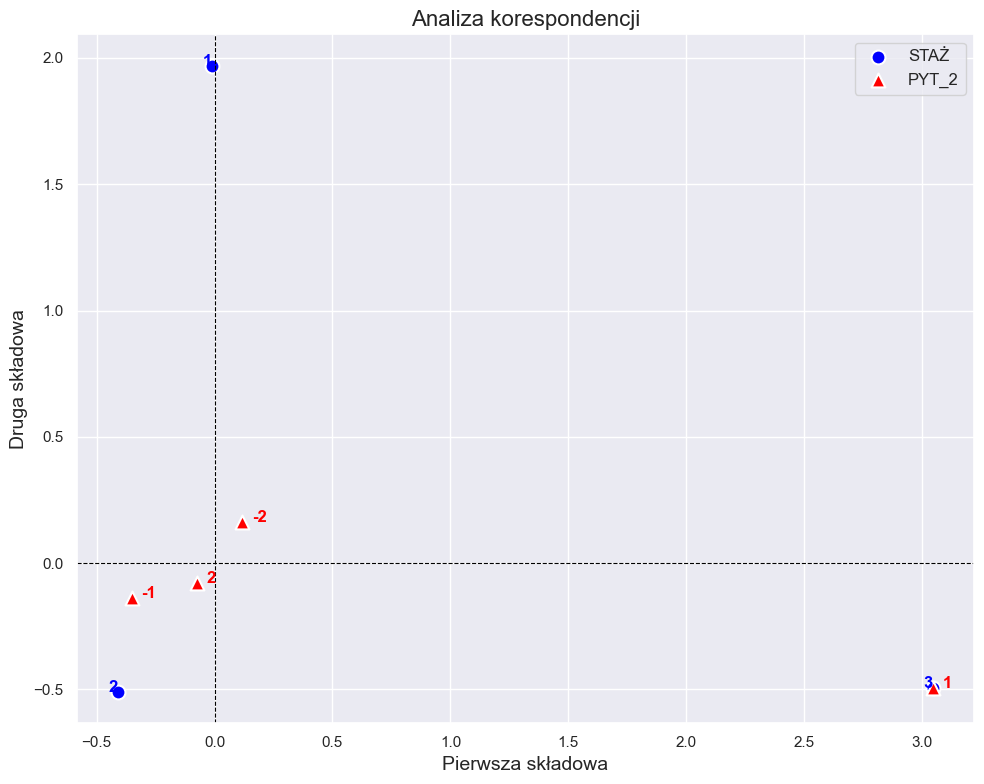

In [64]:
N_matrix = contingency_table.to_numpy()

row_sums = np.sum(N_matrix, axis=1)
column_sums = np.sum(N_matrix, axis=0)
total_sum = np.sum(N_matrix)

row_proportions = row_sums / total_sum
column_proportions = column_sums / total_sum
Dr_matrix = np.diag(row_proportions)
Dc_matrix = np.diag(column_proportions)
P_matrix = N_matrix / total_sum

A_matrix = np.linalg.inv(Dr_matrix)**0.5 @ (P_matrix - np.outer(row_proportions, column_proportions)) @ np.linalg.inv(Dc_matrix)**0.5

U_matrix, singular_values, VT_matrix = svd(A_matrix, full_matrices=False)
Sigma_matrix = diagsvd(singular_values, len(singular_values), len(singular_values))
F_matrix = np.linalg.inv(Dr_matrix)**0.5 @ U_matrix @ Sigma_matrix
G_matrix = np.linalg.inv(Dc_matrix)**0.5 @ VT_matrix.T
eigen_values = singular_values**2

plt.figure(figsize=(10, 8))
plt.scatter(G_matrix[:, 0], G_matrix[:, 1], marker='o', label='STAŻ', color='blue', s=100, edgecolor='w', linewidth=1.5)
plt.scatter(F_matrix[:, 0], F_matrix[:, 1], marker='^', label='PYT_2', color='red', s=100, edgecolor='w', linewidth=1.5)

for x, y, label in zip(F_matrix[:, 0], F_matrix[:, 1], contingency_table.index):
    plt.text(x + 0.04, y, label, color='red', fontsize=12, weight='bold')
for x, y, label in zip(G_matrix[:, 0], G_matrix[:, 1], contingency_table.columns):
    plt.text(x - 0.04, y, label, color='blue', fontsize=12, weight='bold')

plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)

plt.title('Analiza korespondencji', fontsize=16)
plt.xlabel('Pierwsza składowa', fontsize=14)
plt.ylabel('Druga składowa', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Odległości chi-kwadrat między punktami na wykresie wskazują na siłę związku między kategoriami zmiennych. Im bliżej siebie znajdują się punkty, tym silniejsza jest zależność między kategoriami.

Na podstawie naszego wykresu możemy stwierdzić, że

- **STAŻ = 1** znajduje się blisko **PYT_2 = 2** (zdecydowanie się zgadzam), co sugeruje, że osoby z rocznym stażem pracy częściej zdecydowanie zgadzają się z tym, że ich wynagrodzenie jest adekwatne do zakresu obowiązków.

- **STAŻ = 2** znajduje się blisko **PYT_2 = -2** (zdecydowanie się nie zgadzam), co oznacza, że osoby z dwuletnim stażem pracy częściej zdecydowanie nie zgadzają się z tym stwierdzeniem.

- **STAŻ = 3** znajduje się w pobliżu **PYT_2 = 1** (zgadzam się) oraz **PYT_2 = -1** (nie zgadzam się), ale bliżej **PYT_2 = 1**, co sugeruje, że osoby z trzyletnim stażem mają mieszane uczucia, ale są bardziej skłonne zgodzić się, że wynagrodzenie jest adekwatne.



# Zadania dodatkowe

## Zadanie 2

Chcemy pokazać, że
$$ | RR - 1 | < |OR - 1|$$

Wiemy, że:

$$ RR = \frac{\pi_1}{\pi_2}$$

$$ OR = \frac{\pi_1(1-\pi_1)}{\pi_2(1-\pi_2)}$$

Podstawmy do nierówności:

$$ \left| \frac{\pi_1}{\pi_2} - 1 \right| < \left| \frac{\pi_1(1-\pi_1)}{\pi_2(1-\pi_2)} - 1 \right|$$